In [32]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import yaml
from tqdm import tqdm

import sys
sys.path.append('../')
sys.path.append('../../')

from TMaze_new.TMaze_new_src.utils.tmaze import TMazeClassicPassive
from TMaze_new.TMaze_new_src.utils import seeds_list
from TMaze_new.TMaze_new_src.inference.val_tmaze import get_returns_TMaze
from RATE_delete_after import mem_transformer_v2_GTrXL

import torch
import torch.nn as nn

In [84]:
with open("../../TMaze_new/TMaze_new_src/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config["model_mode"] = 'DT'
config["arctitecture_mode"] = 'TrXL'

if config["model_mode"] == 'RATE':
    mem_len = 0
    nmt = 5
    n_head_ca = 4
    mrv_act = 'relu'
    skip_dec_ffn = False
elif config["model_mode"] == 'DT':
    mem_len = 0
    nmt = 0
    n_head_ca = 0
    mrv_act = None
    skip_dec_ffn = False
if config["model_mode"] == 'RMT':
    mem_len = 0
    nmt = 5
    n_head_ca = 0
    mrv_act = 'no_act'
    skip_dec_ffn = False

config['model_config']['skip_dec_ffn'] = skip_dec_ffn

""" ARCHITECTURE MODE """
if config["arctitecture_mode"] == "TrXL":
    config["model_config"]["use_gate"] = False
    config["model_config"]["use_stable_version"] = False
elif config["arctitecture_mode"] == "TrXL-I":
    config["model_config"]["use_gate"] = False
    config["model_config"]["use_stable_version"] = True
elif config["arctitecture_mode"] == "GTrXL":
    config["model_config"]["use_gate"] = True
    config["model_config"]["use_stable_version"] = True     

print(f"Selected Architecture: {config['arctitecture_mode']}")  

""" MODEL MODE """
if config["model_mode"] == "RATE": 
    config["model_config"]["mem_len"] = mem_len
    config["model_config"]["mem_at_end"] = True
    config["model_config"]["num_mem_tokens"] = nmt
    config["model_config"]["n_head_ca"] = n_head_ca
    config["model_config"]["mrv_act"] = mrv_act

elif config["model_mode"] == "DT":
    config["model_config"]["mem_len"] = 0
    config["model_config"]["mem_at_end"] = False
    config["model_config"]["num_mem_tokens"] = 0
    config["model_config"]["n_head_ca"] = 0
    config["training_config"]["context_length"] = config["training_config"]["context_length"] * config["training_config"]["sections"]
    config["training_config"]["sections"] = 1
    max_length = config["training_config"]["context_length"]

elif config["model_mode"] == "DTXL":
    config["model_config"]["mem_len"] = mem_len
    config["model_config"]["mem_at_end"] = False
    config["model_config"]["num_mem_tokens"] = 0
    config["model_config"]["n_head_ca"] = 0
    config["training_config"]["context_length"] = config["training_config"]["context_length"] * config["training_config"]["sections"]
    config["training_config"]["sections"] = 1
    max_length = config["training_config"]["context_length"]

elif config["model_mode"] == "RATEM":
    config["model_config"]["mem_len"] = 0
    config["model_config"]["mem_at_end"] = True
    config["model_config"]["num_mem_tokens"] = nmt
    config["model_config"]["n_head_ca"] = n_head_ca
    config["model_config"]["mrv_act"] = mrv_act
    max_length = config["training_config"]["sections"]*config["training_config"]["context_length"]

elif config["model_mode"] == "RATE_wo_nmt":
    print("Custom Mode!!! RATE wo nmt")
    config["model_config"]["mem_len"] = mem_len
    config["model_config"]["mem_at_end"] = False
    config["model_config"]["num_mem_tokens"] = 0
    config["model_config"]["n_head_ca"] = 0
    max_length = config["training_config"]["sections"]*config["training_config"]["context_length"]

if nmt == 0:
    config["model_config"]["mem_at_end"] = False

model = mem_transformer_v2_GTrXL.MemTransformerLM(**config["model_config"])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Selected Architecture: TrXL
cuda


In [85]:
# ckpt_folder = '../../TMaze_new/rate_3_tmaze_no_curr/RATE_3_nmt_5_nhca_4_arch_mode_TrXL_RATE_min_1_max_3_RUN_1_2024_09_04_23_41_55'
# ckpt_folder = '../../TMaze_new/rate_3_tmaze_no_curr/RATE_3_nmt_5_nhca_4_arch_mode_TrXL_RATE_min_1_max_3_RUN_2_2024_09_05_04_00_31'

ckpt_folder = '../../TMaze_new/dt/DT_fin_no_curr_arch_mode_TrXL_DT_min_1_max_3_RUN_1_2024_09_06_23_13_55'

name = '_save_KTD.pth'

ckpt_path = f'../../TMaze_new/TMaze_new_checkpoints/{ckpt_folder}/'

folder_path = ckpt_path

model.load_state_dict(torch.load(ckpt_path + name, map_location=device), strict=True)
model.to(device)
print(f"model parameters: {sum(p.numel() for p in list(model.parameters()))}")
_ = model.eval()  

model parameters: 2425488


/tmp/ipykernel_1632801/3365691837.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path + name, map_location=device), strict=True)


In [86]:
@torch.no_grad()
def sample(model, x, block_size, steps, sample=False, top_k=None, actions=None, rtgs=None, timestep=None, mem_tokens=1, saved_context=None):
    
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        if actions is not None:
            actions = actions if actions.size(1) <= block_size else actions[:, -block_size:] # crop context if needed
        rtgs = rtgs if rtgs.size(1) <= block_size else rtgs[:, -block_size:] # crop context if needed
        
        if saved_context is not None:
            results = model(x_cond, actions, rtgs, None, timestep, *saved_context, mem_tokens=mem_tokens)
        else:
            results = model(x_cond, actions, rtgs, None, timestep, mem_tokens=mem_tokens) 

        logits = results[0][0][:,-1,:]
        mem_tokens = results[1]
        memory = results[0][2:]
        attn_map = model.attn_map
        attn_map_mrv = model.attention_weights_mrv if config['model_mode'] != 'DT' else None
        
    return logits, mem_tokens, memory, attn_map, attn_map_mrv

def get_returns_TMaze(model, ret, seed, episode_timeout, corridor_length, context_length, device, act_dim, config, create_video=False):
    
    scale = 1
    channels = 5
    max_ep_len = episode_timeout

    env = TMazeClassicPassive(episode_length=episode_timeout, corridor_length=corridor_length, penalty=0, seed=seed, goal_reward=ret)
    state = env.reset() # {x, y, hint}
    np.random.seed(seed)
    where_i = state[0]
    mem_state = state[2]
    mem_state2 = state

    state = np.concatenate((state, np.array([0]))) # {x, y, hint, flag}
    state = np.concatenate((state, np.array([np.random.randint(low=-1, high=1+1)]))) # {x, y, hint, flag, noise}

    if create_video == True:
        print("down, required act: 3" if mem_state == -1.0 else "up,  required act: 1")

    state = torch.tensor(state).reshape(1, 1, channels)
    out_states = []
    out_states.append(state.cpu().numpy())
    done = True
    Flag = 0
    HISTORY_LEN = context_length
    
    rews = []
    states = state.to(device=device, dtype=torch.float32)
    actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
    rewards = torch.zeros(0, device=device, dtype=torch.float32)
    target_return = torch.tensor(ret, device=device, dtype=torch.float32).reshape(1, 1)
    episode_return, episode_length = 0, 0

    mem_tokens = model.mem_tokens.repeat(1, 1, 1).detach() if model.mem_tokens is not None else None
    if mem_tokens is not None:
        memories = [mem_tokens.detach().cpu()]
    else:
        memories = []
    model.cache = mem_tokens.clone() if mem_tokens is not None else None
    
    saved_context = None
    segment = 0
    prompt_steps = 0
    act = None
    act_list= []

    switcher = False
    attn_maps = []
    attn_maps_mrv = []
    attn_maps_seg = []
    mem_tokens_lst = [mem_tokens]
    

    for t in tqdm(range(max_ep_len)):
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
        rewards = torch.cat([rewards, torch.zeros(1, device=device)])
        
        if config["model_mode"] != 'DT' and config["model_mode"] != 'DTXL':
            if actions.shape[0] > HISTORY_LEN:
                segment+=1
                
                if prompt_steps==0:
                    actions = actions[-1:,:]
                    states = states[:, -1:, :]
                    target_return = target_return[:,-1:]
                    
                if t%(context_length)==0:
                    if create_video:
                        out = torch.norm(mem_tokens).item() if mem_tokens is not None else None
                        print(f't: {t}, NEW MEMORY: {out}')
                        
                    mem_tokens = new_mem
                    memories.append(mem_tokens.detach().cpu())
                    saved_context = new_notes
                
        else:
            if actions.shape[0] > HISTORY_LEN:
                segment+=1
                
                if prompt_steps==0:
                    actions = actions[1:,:]
                    states = states[:, 1:, :]
                    target_return = target_return[:,1:]
                    
                if t%(context_length)==0:
                    if create_video:
                        out = torch.norm(mem_tokens).item() if mem_tokens is not None else None
                        print(f't: {t}, NEW MEMORY: {out}')
                    mem_tokens = new_mem
                    saved_context = new_notes
                
        if t==0:
            act_to_pass = None
        else:
            act_to_pass = actions.unsqueeze(0)[:, 1:, :]
            if act_to_pass.shape[1] == 0:
                act_to_pass = None 
        
        sampled_action, new_mem, new_notes, attn_map, attn_map_mrv = sample(model=model,  
                                                        x=states[:, :, 1:],
                                                        block_size=HISTORY_LEN, 
                                                        steps=1, 
                                                        sample=True, 
                                                        actions=act_to_pass, 
                                                        rtgs=target_return.unsqueeze(-1), 
                                                        mem_tokens=mem_tokens,
                                                        saved_context=saved_context)
        mem_tokens_lst.append(new_mem)
        if t > 0 and t % (context_length-1) == 0 and switcher == False:
            switcher = True

        act = torch.argmax(torch.softmax(sampled_action, dim=-1).squeeze()).item()
        if create_video:
            print(t, "act", act, np.round(torch.softmax(sampled_action, dim=-1).squeeze().detach().cpu().numpy(), 3), "\tstate:", int(where_i), states[:, -1:, :].detach().cpu().numpy())
        actions[-1, :] = act
        act_list.append(act)
        state, reward, done, info = env.step(act)
        
        if t < config["data_config"]["hint_steps"]-1:
            state[2] = mem_state2[2]
        
         # {x, y, hint} -> {x, y, hint, flag}
        if state[0] != env.corridor_length:
            state = np.concatenate((state, np.array([0])))
        else:
            if Flag != 1:
                state = np.concatenate((state, np.array([1])))
                Flag = 1
            else:
                state = np.concatenate((state, np.array([0])))
                
        # {x, y, hint, flag} -> {x, y, hint, flag, noise}
        state = np.concatenate((state, np.array([np.random.randint(low=-1, high=1+1)])))
        
        
        delta_t = env.time_step - env.corridor_length - 1
        where_i = state[0]
        state = state.reshape(1, 1, channels)
        out_states.append(state)
        
        rews.append(reward)
        cur_state = torch.from_numpy(state).to(device=device).float()
        states = torch.cat([states, cur_state], dim=1)
        rewards[-1] = reward
        pred_return = target_return[0,-1] - (reward/scale)
        target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
        episode_return += reward
        episode_length += 1
        
        attn_maps.append(attn_map)
        attn_maps_mrv.append(attn_map_mrv)
        
        if (t+1) % (context_length) == 0 and t > 0:
            attn_maps_seg.append(attn_map)
            
        if done:
            if create_video == True:
                if np.round(where_i, 4) == np.round(corridor_length, 4):
                    print("Junction achieved 😀 ✅✅✅")
                    print("Chosen act:", "up" if act == 1 else "down" if act == 3 else "wrong")
                    if mem_state == -1 and act == 3:
                        print("Correct choice 😀 ✅✅✅")
                    elif mem_state == 1 and act == 1:
                        print("Correct choice 😀 ✅✅✅")
                    else:
                        print("Wrong choice 😭 ⛔️⛔️⛔️")
                else:
                    print("Junction is not achieved 😭 ⛔️⛔️⛔️")
                
                print(f"{np.round(torch.softmax(sampled_action, dim=-1).squeeze().detach().cpu().numpy(),2)}")
            break  
    if create_video == True:
        print(f"Final position: [{int(where_i)}, {int(np.round(states.squeeze()[-1].tolist()[0 if channels == 3 else 1]))}] / [{int(corridor_length)}, {int(mem_state)}]")
        print("\n")
        
    return reward, act_list, t, np.array(out_states).squeeze(), delta_t, attn_maps, attn_maps_seg, memories, attn_maps_mrv, mem_tokens_lst

In [87]:
segments = 3
seg_len = 5
episode_timeout = seg_len*segments
corridor_length = seg_len*segments - 2
create_video = False
seed = 1

episode_return, act_list, t, states, _, attn_maps, attn_maps_seg, \
    memories, attn_maps_mrv, mem_tokens_lst = get_returns_TMaze(model=model, ret=config["data_config"]["desired_reward"], seed=seed, 
                                                                    episode_timeout=episode_timeout, corridor_length=corridor_length, 
                                                                    context_length=config["training_config"]["context_length"], 
                                                                    device=device, act_dim=config["model_config"]["ACTION_DIM"], 
                                                                    config=config, create_video=create_video)

print(episode_return)

 87%|████████▋ | 13/15 [00:00<00:00, 111.16it/s]

1.0


In [88]:
cos = nn.CosineSimilarity(dim=-1, eps=1e-6)

mem_tokens_to_print = {nmt: [] for nmt in range(mem_tokens_lst[0].shape[0])}

for i in range(1, len(mem_tokens_lst)):
    for nmt in range(mem_tokens_lst[0].shape[0]):
        cos_sim = cos(mem_tokens_lst[i][nmt].squeeze(), mem_tokens_lst[i-1][nmt].squeeze()).item()
        # if nmt == 2:
        #     cos_sim += 0.05
        mem_tokens_to_print[nmt].append(cos_sim)

fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=300)

for nmt in range(len(mem_tokens_lst[0])):
    ax.plot(range(len(mem_tokens_to_print[nmt])), mem_tokens_to_print[nmt], label=f'Mem Token {nmt}')

for i in range(len(mem_tokens_lst)//30+1):
    ax.axvline(x=i*30, color='r', linestyle='--')

fontsize = 16

ax.set_title('Cosine Similarity between Memory Tokens', fontsize=fontsize+2)  # Increased font size
ax.set_xlabel('Time Step', fontsize=fontsize)  # Increased font size
ax.set_ylabel('Cosine Similarity', fontsize=fontsize)  # Increased font size
ax.legend(fontsize=fontsize-2)  # Increased font size for legend

ax.tick_params(axis='both', which='major', labelsize=fontsize)  # Increased font size for tick labels

plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

In [89]:
n_heads = attn_maps[0].shape[-1]
print(f"n_heads: {n_heads}")

n_heads: 10


0 41


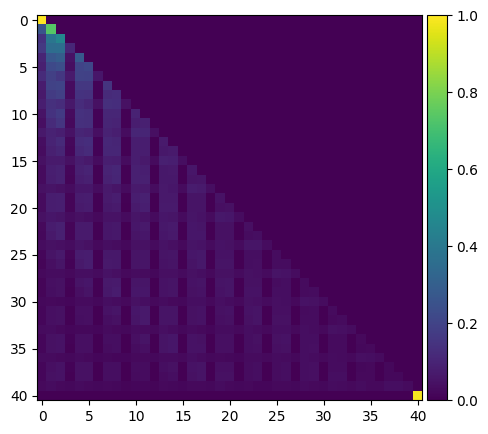

1 41


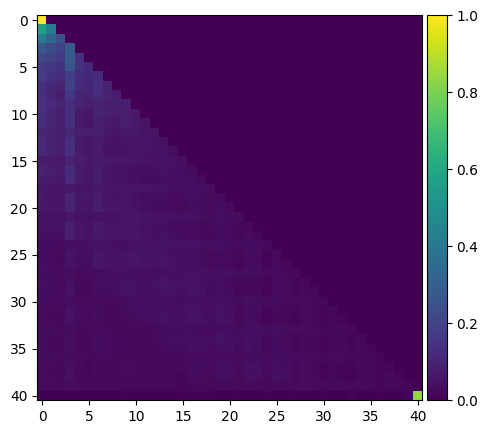

2 41


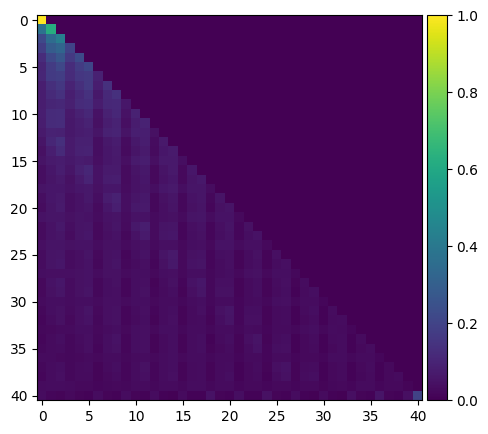

3 41


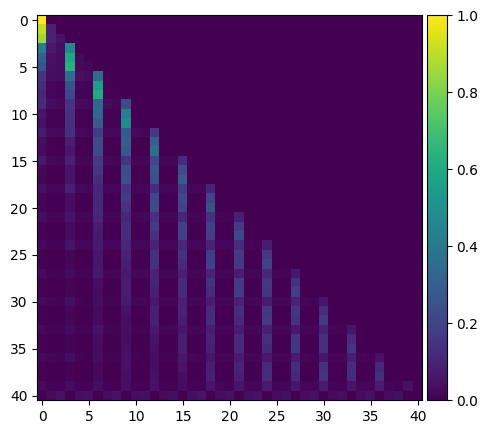

4 41


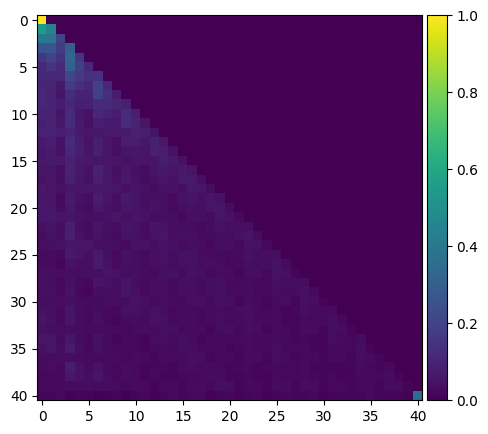

5 41


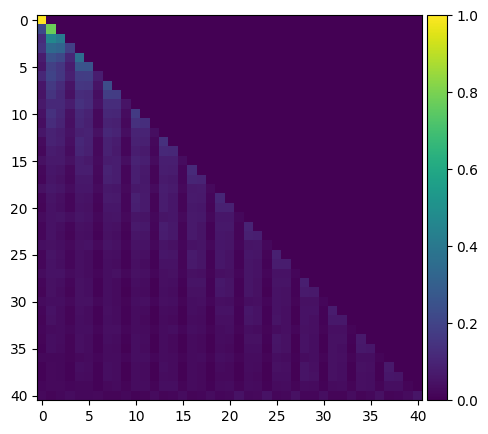

6 41


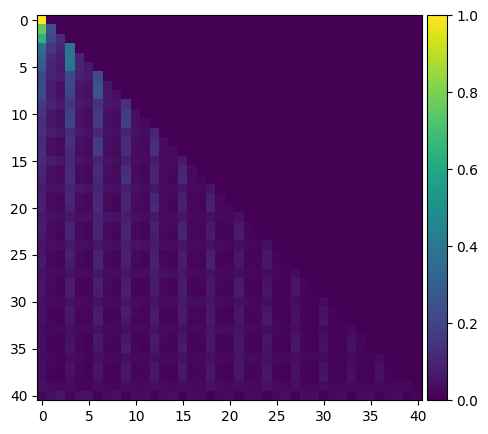

7 41


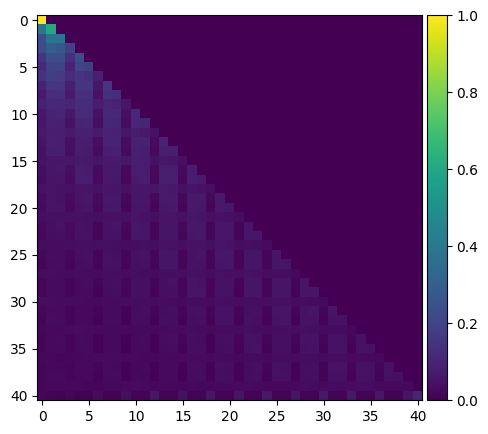

8 41


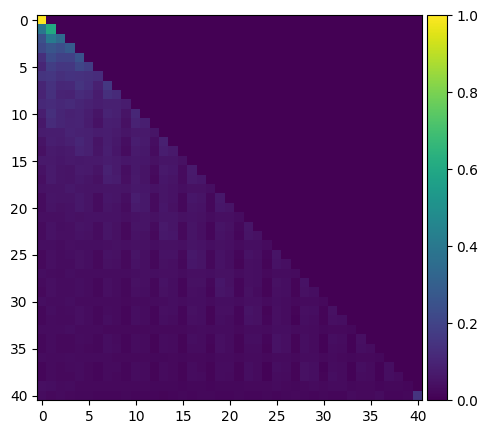

9 41


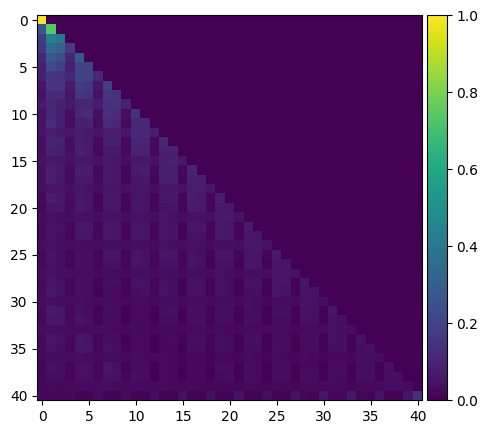

In [90]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fontsize = 16

for head in range(n_heads):
    # head = 0

    max_val = max(attn_map[:, :, 0, head].shape[1] for attn_map in attn_maps)
    print(head, max_val)

    if config["model_mode"] == "RATE" or "DT":
        attn_seg = [torch.softmax(attn_map[:, :, 0, head], dim=1).numpy() for attn_map in attn_maps if attn_map[:, :, 0, head].shape == (max_val, max_val)]
    else:
        attn_seg = attn_maps_seg

    if config["model_mode"] == "RATE":
        first_3_seg_attn = np.concatenate((attn_seg[0], attn_seg[len(attn_seg)//2], attn_seg[-1]), axis=1)
    else:
        first_3_seg_attn = attn_seg[-1]

    fig, ax = plt.subplots(figsize=(15, 5))
    im = ax.imshow(first_3_seg_attn)

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(ax)
    # Append axes to the right of ax, with 5% width of ax
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # Create colorbar in the new axes

    # ax.set_title(f"RATE Head {head}", fontsize=fontsize+2)
    plt.colorbar(im, cax=cax)

    plt.show()

In [27]:
len(mem_tokens_lst)

150

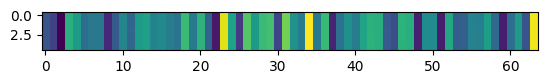

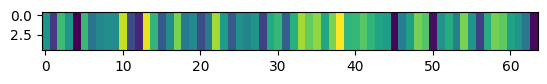

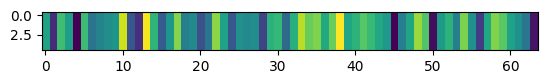

In [69]:
for i in range(0, len(mem_tokens_lst)-1, 5):
    plt.imshow(mem_tokens_lst[i][:, 0, :].detach().cpu().numpy())
    plt.show()


4


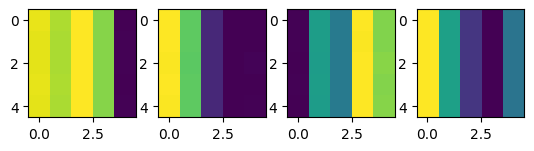

8


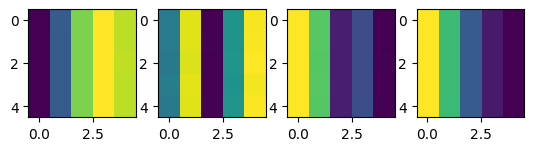

12


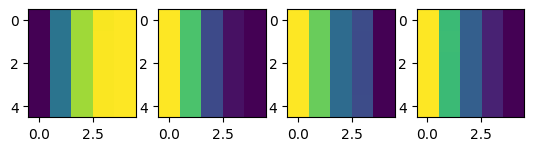

In [70]:
for i in range(len(attn_maps_mrv)):
    if i % 4 == 0 and i != 0:
        print(i)
        fig, ax = plt.subplots(1, 4)
        for head in range(attn_maps_mrv[i].shape[1]):
            ax[head].imshow(attn_maps_mrv[i][:, head, :, :].squeeze(0).detach().cpu().numpy())
        plt.show()  # Moved outside the inner loop to show all subplots together